In [2]:
from scraper.grid_builder import GridBuilder
from grid_manager import GRID_INDICES
import numpy as np
from scraper.graph_loader import GraphLoader
from scraper.geometry_processor import GeometryProcessor

ModuleNotFoundError: No module named 'srtm'

### Download mesh and get grid from OSM

#### Current version

In [ ]:
cityname = "Kraków"

loader = GraphLoader()

graph = loader.load_graph(cityname)

edges = loader.get_edges_measurements(graph)

gdf_edges = loader.convert_to_gdf(edges)

geometry_processor = GeometryProcessor()
gdf_edges["geometry"] = gdf_edges.apply(lambda row: geometry_processor.get_edge_polygon(row), axis=1)

# np_streets = get_city_grid(f"{cityname}, Poland")
# print("generating altitudes")
# np_altitudes = np.zeros(np_streets.shape, dtype=np.float64) - 10
# print("concatenating")
# grid = np.concat(
#     [
#         np_streets[:, :, np.newaxis],
#         np_altitudes[:, :, np.newaxis]
#     ],
#     2
# )
# write(grid, cityname)
# print(f"wymiary siatki punktów: {grid.shape}")
# print(f"punkt (100, 200): droga {grid[100, 200, GRID_INDICES.IS_STREET_INDEX]}, wysokość: {grid[100, 200, GRID_INDICES.ALTITUDE_INDEX]}")

Roads with 'width' attribute: 8480
Roads without 'width' attribute: 12782


In [ ]:
test = [1,2]
test[2:]

[]

### Data management

In [ ]:
from grid_manager import GridManager
import numpy as np

filename = "test2.dat"

man = GridManager(filename, 2000, 2000, 0.0, 0.0, 1, 3, 3)

a = np.zeros((2000, 2000, 2), dtype=np.float64)
man.write_segment(a[:2,:3, :] + 1, 666, 0)
man.write_segment(a[:3,:2, :] + 2, 0, 666)

print(f"1: {man.read_segment(666, 0)}")
print(f"2: {man.read_segment(0, 666)}")

print(man.get_metadata())


AssertionError: Given segment has wrong height 3. It belongs to the last row, thus its height is expected to be 2.

### Streets discovery

In [14]:
import matplotlib.pyplot as plt

def show_crossroads(img_height, img_width, conflictless_crossroads, conflicting_crossroads):
    fig, axs = plt.subplots(  max(2, len(conflictless_crossroads), len(conflicting_crossroads)), 6, figsize=(10,5))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("junctions")
    axs[0, 2].set_title("conflicts")
    axs[0, 3].set_title("conflicting")
    axs[0, 4].set_title("junctions")
    axs[0, 5].set_title("conflicts")


    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 0].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 1].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 2].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 3].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 4].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 5].imshow(crossroad_image)


In [21]:
import matplotlib.pyplot as plt

def show_streets(img_height, img_width, conflictless_streets, conflicting_streets):
    fig, axs = plt.subplots(  max(2, len(conflictless_streets), len(conflicting_streets)), 4, figsize=(10,8))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("conflicts")
    axs[0, 2].set_title("conflicting")
    axs[0, 3].set_title("conflicts")


    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 0].imshow(street_image)
    
    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 1].imshow(street_image)

    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 2].imshow(street_image)
    
    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 3].imshow(street_image)


#### Diamond

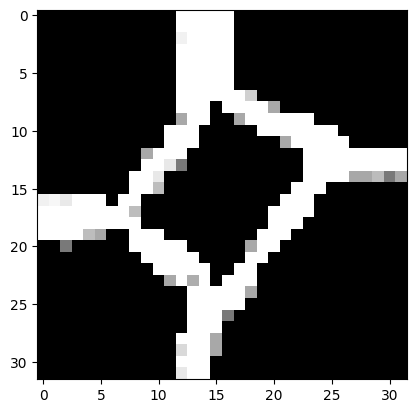

In [25]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/diamond.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

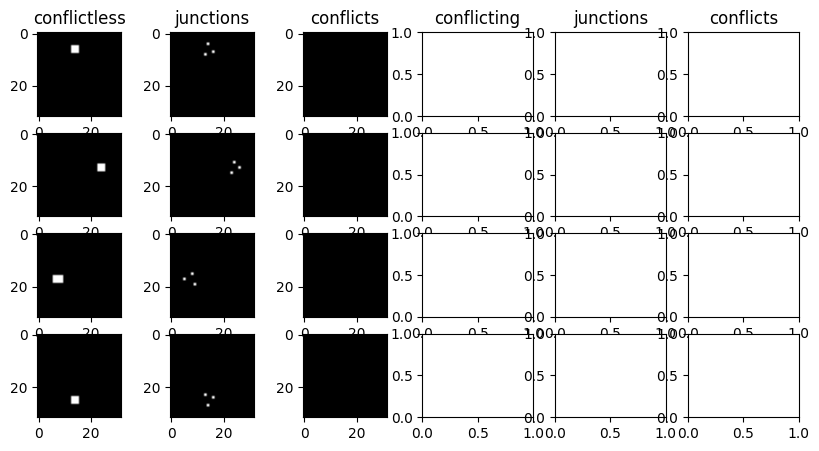

In [26]:
show_crossroads(height, width, conflictless_crossroads, conflicting_crossroads)

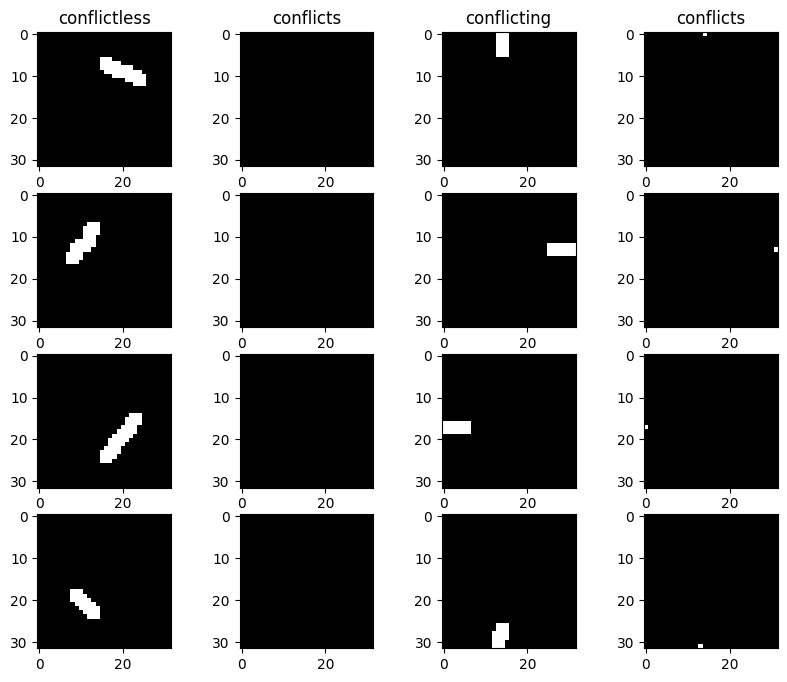

In [27]:
show_streets(height, width, conflictless_streets, conflicting_streets)

#### Conflicting crossroad and dead-end

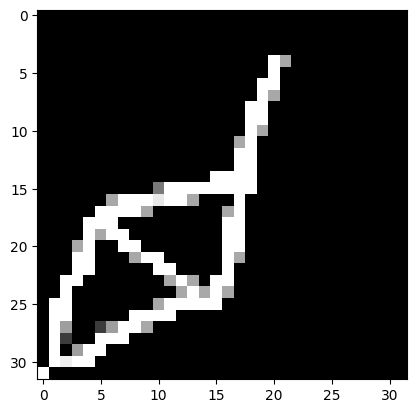

In [28]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/crossroad_conflict_deadend.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

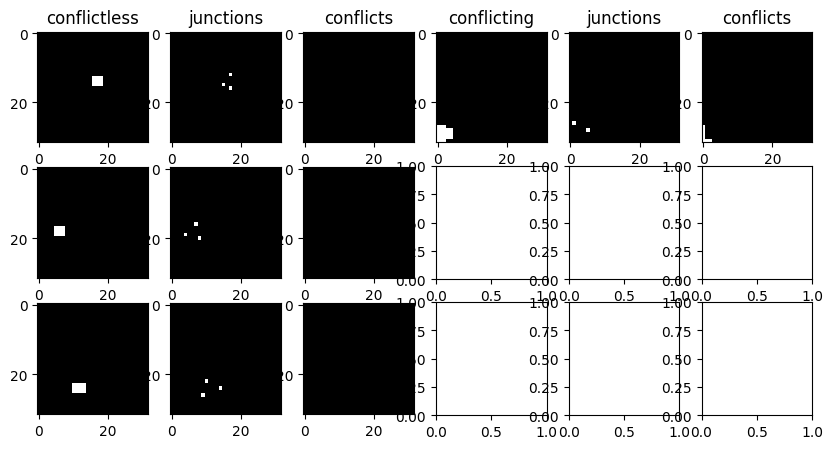

In [29]:
show_crossroads(width, height, conflictless_crossroads, conflicting_crossroads)

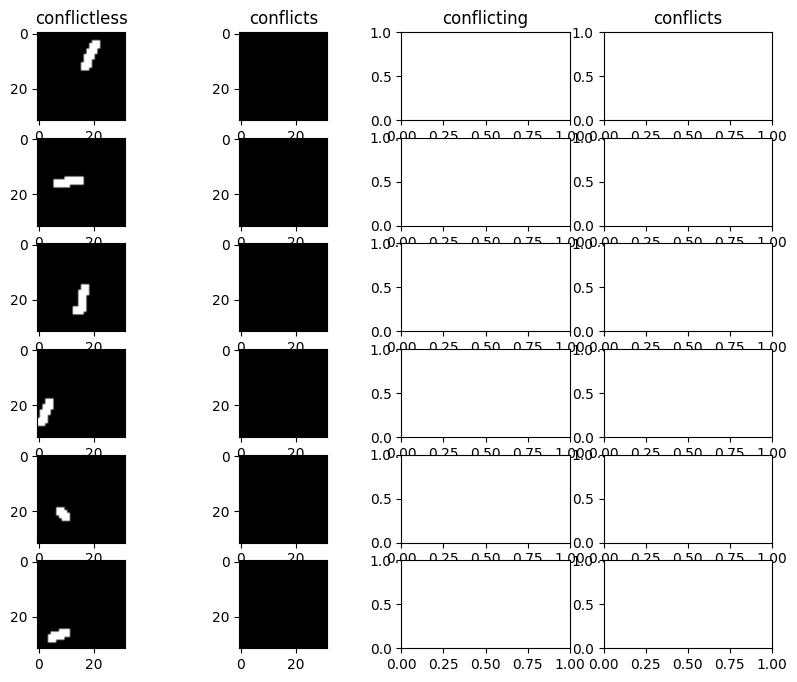

In [30]:
show_streets(width, height, conflictless_streets, conflicting_streets)